<a href="https://colab.research.google.com/github/GwiHwan-Go/Reproduce_CutMix/blob/main/Training/CutMix.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# !pip install torch
# !pip install torchvision
# !pip install pretrainedmodels

import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import joblib
from tqdm.notebook import tqdm
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
########## YOUR DIR
import sys
sys.path.append("..") ## to import parent's folder
from Local import DIR 
########### YOUR DIR

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read & Split data

In [2]:
from sklearn.model_selection import train_test_split

df_train = pd.read_csv(f"{DIR}/train.csv")
X_train, X_val = train_test_split(df_train, test_size=0.2)

## Define augmentations


In [3]:
import torch
import torchvision.transforms as T

train_augmentation = T.Compose([
    T.ToTensor(),
    T.RandomRotation(20),
    ##we can add more augmentation##
])

valid_augmentation = T.Compose([
    T.ToTensor(),
])

## Make model, optimizer and loss function - ResNet34

In [4]:
from torch.nn import Linear
import pretrainedmodels

model_name = 'resnet34'
model = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

## 우리 이미지 사이즈에 맞게 튜닝
in_features = model.last_linear.in_features
model.last_linear = torch.nn.Linear(in_features, 186) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                      mode='max',
                                                      verbose=True,
                                                      patience=7,
                                                      factor=0.5)

cuda


## Define Dataset => Load with Data Loader

In [5]:
from torch.utils.data import Dataset, DataLoader

## Dataset Description : https://www.kaggle.com/competitions/bengaliai-cv19/data
class BengaliDataset(Dataset):
    def __init__(self, csv, img_height, img_width, transform):
        self.csv = csv.reset_index()
        self.img_ids = csv['image_id'].values
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = joblib.load(f'{DIR}/train_images/{img_id}.pkl')
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        #img = 255 - img
        img = 255 - img
        #img = np.expand_dims(img, axis=2)
        img = img[:, :, np.newaxis]

        
        img = np.repeat(img, 3, 2)
        if self.transform is not None:
            img = self.transform(img)
        
        label_1 = self.csv.iloc[index].grapheme_root #-167
        label_2 = self.csv.iloc[index].vowel_diacritic #-10
        label_3 = self.csv.iloc[index].consonant_diacritic #-6
        
        return img, np.array([label_1, label_2, label_3])
        
train_dataset = BengaliDataset(csv=X_train,
                            img_height=137,
                            img_width=236,
                            transform=train_augmentation)
valid_dataset = BengaliDataset(csv=X_val,
                            img_height=137,
                            img_width=236,
                            transform=valid_augmentation)
train_loader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=128
                       )
valid_loader = DataLoader(valid_dataset,
                       shuffle=False,
                        num_workers=0,
                        batch_size=128
                       )

class labels: torch.Size([128, 3])


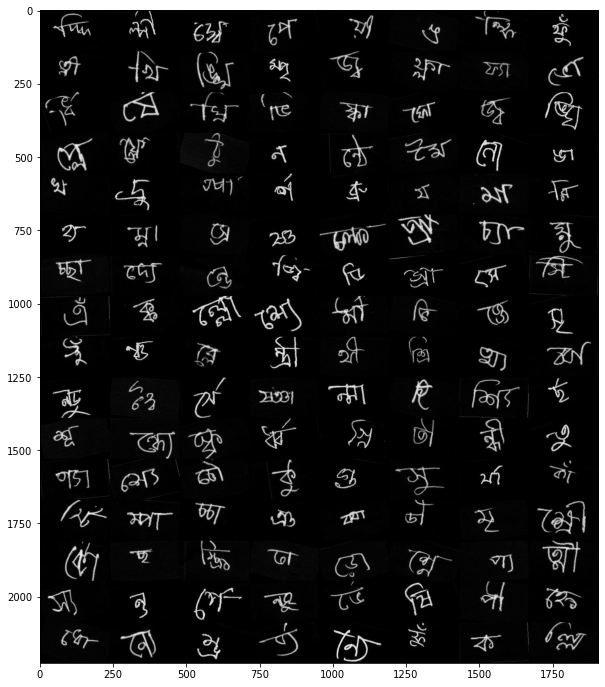

In [26]:
import torchvision
if device=="cpu" :
    os.environ["OMP_NUM_THREADS"]="1"  # If you are using CPU
batch = next(iter(train_loader))
images, labels = batch
plt.figure(figsize=(12,12))
print(f"class labels: {labels.shape}")


grid = torchvision.utils.make_grid(tensor=images, nrow=8)
copied_images = images.clone().detach()
plt.imshow(grid.permute(1,2,0))

## CutMix

In [7]:
def cut(size, lam):
    
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [8]:
lam = np.random.beta(1.0, 1.0) # 
rand_index = torch.randperm(images.size()[0])

In [9]:
targets_gra, targets_vow, targets_con = labels[:, 0], labels[:, 1], labels[:, 2]
shuffled_targets_gra = targets_gra[rand_index] #shape 128
shuffled_targets_vow = targets_vow[rand_index] #shape 128
shuffled_targets_con = targets_con[rand_index] #shape 128
print(f"targets_gra : {targets_gra[:5]}\ntargets_vow : {targets_vow[:5]}\ntargets_con : {targets_con[:5]}")

targets_gra : tensor([123,   9,  36,  65,  96])
targets_vow : tensor([1, 0, 0, 0, 0])
targets_con : tensor([4, 1, 0, 4, 0])


In [17]:
original_images = images.clone().detach() 
bbx1, bby1, bbx2, bby2 = cut(images.size(), lam) # define a box to cut and mix
images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix

In [18]:
lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))

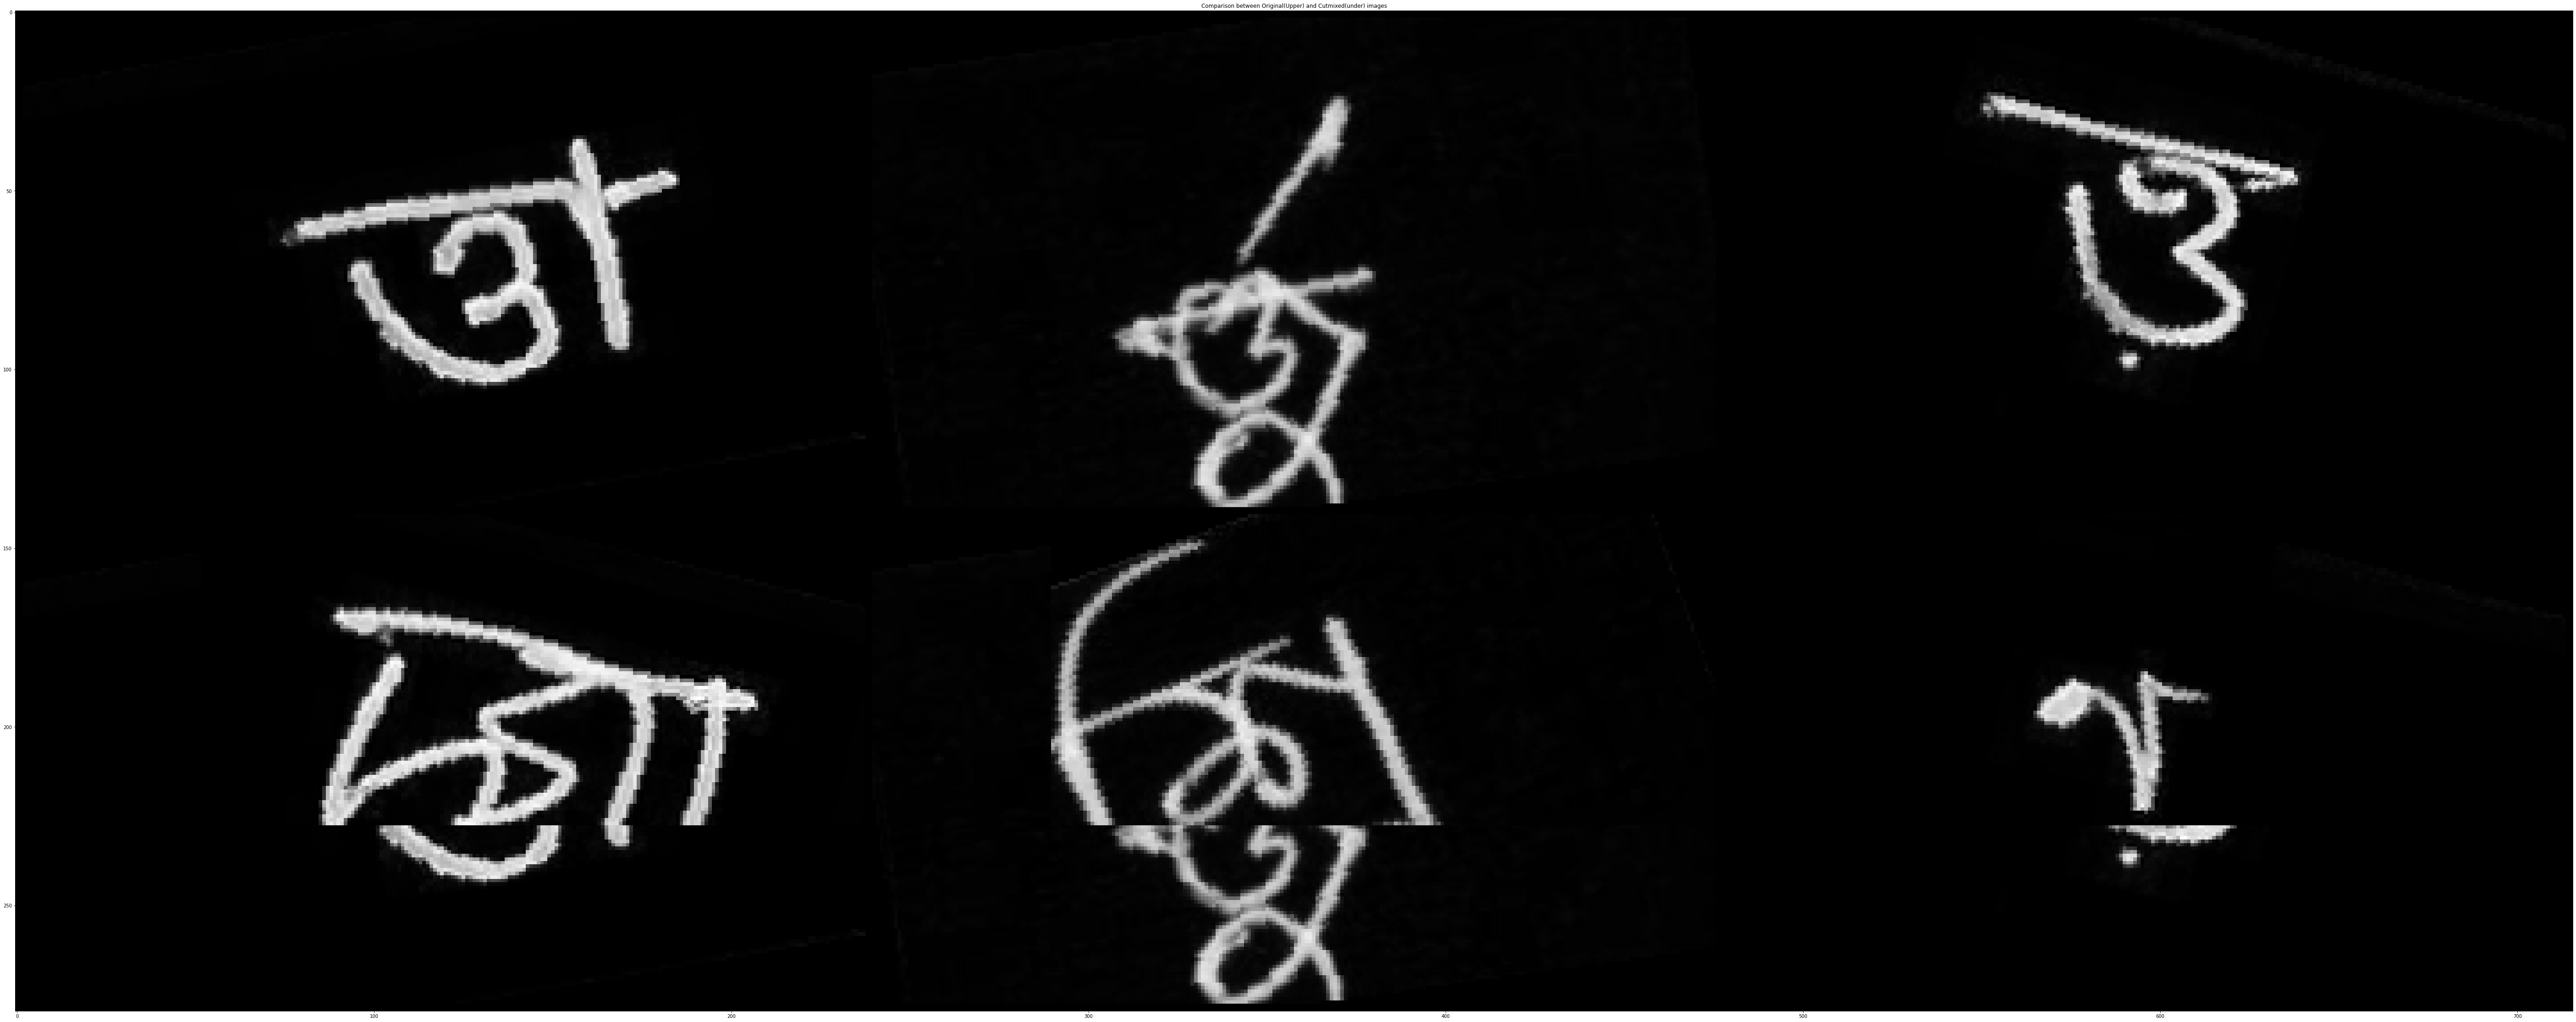

In [25]:
def show_cutMixed_compare(origin, new, nums_show):
    rand_index = torch.randperm(origin.size()[0])[:nums_show]
    to_compare = torch.cat([origin[rand_index,:,:],new[rand_index,:,:]],dim=0)
    plt.figure(figsize=(100,100))
    grid = torchvision.utils.make_grid(tensor=to_compare, nrow=nums_show)
    plt.title("Comparison between Original(Upper) and Cutmixed(under) images")
    plt.imshow(grid.permute(1,2,0))

show_cutMixed_compare(original_images, images, 3)

## Training

In [27]:
logits = model(images.to(device))

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
grapheme = logits[:,:168]
vowel = logits[:, 168:179]
cons = logits[:, 179:]

In [ ]:
loss1 = loss_fn(grapheme, targets_gra) * lam + loss_fn(grapheme, shuffled_targets_gra) * (1. - lam)
loss2 = loss_fn(vowel, targets_vow) * lam + loss_fn(vowel, shuffled_targets_vow) * (1. - lam)
loss3 = loss_fn(cons, targets_con) * lam + loss_fn(cons, shuffled_targets_con) * (1. - lam)
loss = 0.5 * loss1 + 0.25 * loss2 + 0.25 * loss3

In [ ]:
for e in range(100):
    train_loss = []
    model.train()

    for inputs, targets in tqdm(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        if np.random.rand() < 0.5:
            logits = model(inputs)
            grapheme = logits[:, :168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]

            loss = loss_fn(grapheme, targets[:, 0]) + loss_fn(vowel, targets[:, 1]) + loss_fn(cons, targets[:, 2])

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.item())
        else:
            
            lam = np.random.beta(1.0, 1.0) 
            rand_index = torch.randperm(inputs.size()[0])
            
            targets_gra = targets[:, 0]
            targets_vow = targets[:, 1]
            targets_con = targets[:, 2]
            
            shuffled_targets_gra = targets_gra[rand_index]
            shuffled_targets_vow = targets_vow[rand_index]
            shuffled_targets_con = targets_con[rand_index]
            
            bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
            inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
            
            logits = model(inputs)

            grapheme = logits[:,:168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]
            
            loss1 = loss_fn(grapheme, targets_gra) * lam + loss_fn(grapheme, shuffled_targets_gra) * (1. - lam)
            loss2 = loss_fn(vowel, targets_vow) * lam + loss_fn(vowel, shuffled_targets_vow) * (1. - lam)
            loss3 = loss_fn(cons, targets_con) * lam + loss_fn(cons, shuffled_targets_con) * (1. - lam)
            
            loss = 0.5 * loss1 + 0.25 * loss2 + 0.25 * loss3
            
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.item())
            
            
            
            
    val_loss = []
    val_true = []
    val_pred = []

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(vld_loader):
            inputs = inputs.cuda()
            targets = targets.cuda()

            logits = model(inputs)

            grapheme = logits[:, :168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]

            loss = loss_fn(grapheme, targets[:, 0]) + loss_fn(vowel, targets[:, 1]) + loss_fn(cons, targets[:, 2])

            val_loss.append(loss.item())

            grapheme = grapheme.cpu().argmax(dim=1).data.numpy()
            vowel = vowel.cpu().argmax(dim=1).data.numpy()
            cons = cons.cpu().argmax(dim=1).data.numpy()

            val_true.append(targets.cpu().numpy())
            val_pred.append(np.stack([grapheme, vowel, cons], axis=1))

    val_true = np.concatenate(val_true)
    val_pred = np.concatenate(val_pred)

    val_loss = np.mean(val_loss)
    train_loss = np.mean(train_loss)

    score_g = recall_score(val_true[:, 0], val_pred[:, 0], average='macro')
    score_v = recall_score(val_true[:, 1], val_pred[:, 1], average='macro')
    score_c = recall_score(val_true[:, 2], val_pred[:, 2], average='macro')

    final_score = np.average([score_g, score_v, score_c], weights=[2, 1, 1])

    print(f'train_loss: {train_loss:.5f}; val_loss: {val_loss:.5f}; score: {final_score:.5f}')
    print(f'score_g: {score_g:.5f}; score_v: {score_v: .5f}, score_c: {score_c: .5f}')



    if final_score > best_score:
        best_score = final_score

        state_dict = model.cpu().state_dict()
        model = model.cuda()
        torch.save(state_dict, "model.pt")